In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

In [3]:
df = pd.read_csv('../Data/Real_Estate_Model.csv')

In [4]:
df['state'] = df['state'].astype('category')
df['city'] = df['city'].astype('category')

In [ ]:
X = df[['bed', 'bath', 'state', 'city', 'house_size']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    learning_rate=0.05,
    verbose=1,
    random_state=42,
    eval_metric='mape' 
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    )


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7268
[LightGBM] [Info] Number of data points in the train set: 1146051, number of used features: 5
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Start training from score 390953.425775


LGBMRegressor(eval_metric='mape', learning_rate=0.05, objective='regression',
              random_state=42, verbose=1)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'max_depth': [1, 6, 10, 15],
    'num_leaves': [15, 31, 63, 127],
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_absolute_percentage_error',
    cv=2,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_pred = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, best_pred)
rmse_best = np.sqrt(mean_squared_error(y_test, best_pred))
mape_best = np.mean(np.abs((y_test - best_pred) / y_test)) * 100
r2_best = r2_score(y_test, best_pred)

print(f"Best Model Performance:")
print(f"MAE: {mae_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"MAPE: {mape_best:.4f}")
print(f"R2: {r2_best:.4f}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7268
[LightGBM] [Info] Number of data points in the train set: 1146051, number of used features: 5
[LightGBM] [Info] Start training from score 390953.425775
[LightGBM] [Warning] Unknown parameter: eval_metric
Best Model Performance:
MAE: 79576.6841
RMSE: 113146.9699
MAPE: 27.4228
R2: 0.7277


In [8]:
bins = [0, 300_000, 400_000, 500_000, 1_000_000, float('inf')]
labels = ['<300k', '300k-400k', '400k-500k', '500k-1M', '1M+']

price_segments = pd.cut(y_test, bins=bins, labels=labels)
segment_df = pd.DataFrame({'actual': y_test, 'pred': best_pred, 'segment': price_segments})
segment_df['pct_error'] = np.abs(segment_df['actual'] - segment_df['pred']) / segment_df['actual'] * 100

mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()
print(mape_by_segment)

segment
<300k        42.411164
300k-400k    17.507591
400k-500k    15.949219
500k-1M      16.713628
1M+                NaN
Name: pct_error, dtype: float64


C:\Users\tomas\AppData\Local\Temp\ipykernel_16940\3658000176.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()


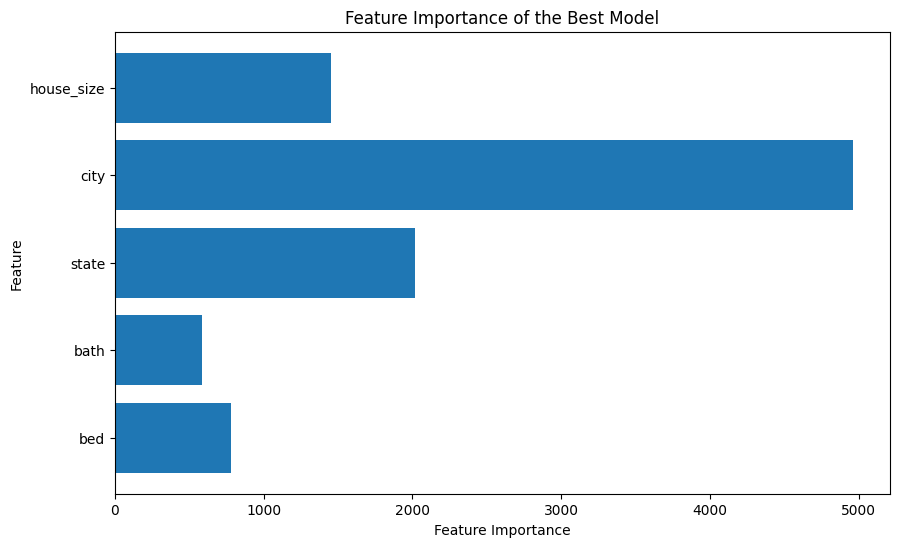

In [9]:
best_feature_importance = best_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, best_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best Model')
plt.show()

XGBoost model performed slightly better. Therefore, I will use XGBoost for my app. 